# Introduction to Neuroinformatics
## Exercise session 2: Passive membrane properties

Welcome to the second exercise session of the introduction to neuroinformatics course. This exerciese session will dive deeper into the RC circuits explored in the last exercise session and model some simple properties of neurons.

# Table of contents

* [Packages](#packages)
* [1: The parallel RC circuit](#prc)
    * [1.1: Charging the capacitor in the parallel RC circuit](#cprc)
    * [1.2: The neuronal membrane: Multiple conductances](#tnm)
* [2: Cable equation](#ce)
    * [2.1: Cable resistance](#cr)
    * [2.2 The cable equation](#tce)
    * [2.3 Steady-state solution (infinite cable)](#sss)
    * [2.4: An axon with three injection sites](#axon)
* [3: Integrate-and-Fire neuron and delayed synaptic inputs](#if)
    * [3.1: Delays: How cable theory affects synaptic inputs](#cable)
    * [3.2: The Integrate-and-No-Fire Model](#inf)


# Packages <a class="anchor" id="packages"></a>

This notebook was <font color='red'>**designed to be run in colab**</font>. We have included code blocks to allow the possibility of running the notebook locally, but due to the vastness of peoples' setups, we do not support it much further.

If you wish to continue in Colab, click on the "Copy to Drive" button to be able to save your progress.

The following cells are used to install the necessary packages and libraries for the exercise:

In [41]:
!which python  # This displays which python is being used
!pwd # This displays the current directory

/usr/local/bin/python
/content


In [42]:
!pip3 install --quiet ipywidgets ipympl wget # Install necessary packages

In [43]:
platform = 'notebook'
try:
    import google.colab
    from google.colab import output
    platform = 'colab'
    output.enable_custom_widget_manager()
except:
    pass
print(f"platform: {platform}")

platform: colab


In [44]:
if platform == 'colab':
    %matplotlib widget
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    %matplotlib inline


In [45]:
import wget
import os

# Define the URL and the output directory
url = 'https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/ex2/utils_ex2/utils.py'
output_dir = 'utils_ex2'

if not os.path.exists(output_dir):
    # Create the directory if it doesn't already exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the file into the specified directory
    print(f"Downloading file to '{output_dir}'...")
    filename = wget.download(url, out=output_dir)
    print(f"\nFile successfully downloaded as: {filename}")

## 1.1: Charging the capacitor in the parallel RC circuit <a class="anchor" id="cprc"></a>

In the last exercise, we took a closer look at the <ins>Nernst equation</ins> and the <ins>GHK equation</ins>. We also introduced the <ins>series RC circuit</ins> and the <ins>time constant</ins>.

These concepts help us to understand further how voltage gradients are established across cell membranes and how the temporal dynamics of these gradients charge and discharge a capacitor.

In fact, we can <ins>model the passive properties of real neuronal cell membranes</ins> using the **parallel RC circuit** (note that the last exercise did only intruduce the series RC circuit).
For this, we need an electrical circuit with a <ins>**capacitor** in parallel with a **resistor**</ins> that is <ins>in series with a **voltage source**</ins> (see figure below).
- The **capacitor** represents the **lipid bilayer** of the membrane.
- The **voltage source** represents the **Nernst potential** for a given ion.
- The **resistor** represent the **ion channels** (**conductances**) in the membrane for a given ion.


![My Image](https://github.com/ManteLab/Iton_notebooks_public/blob/ex2/utils_ex2/ex2_parallel.png?raw=true)

In section 2.a from the last exercise we used Euler's method to find the numerical solution for

$\begin{aligned}
    \frac{dV_C}{dt} = \frac{V - V_C}{R \cdot C} \\
    \end{aligned}$


The solution was



$V_C(t + \Delta t) = V_C(t) + \frac{V - V_C(t)}{R \cdot C} \cdot \Delta t$ = $(1 - \frac{\Delta t}{R \cdot C}) \cdot V_C(t) + \frac{\Delta t}{R \cdot C} \cdot V$

This equation nicely shows how the voltage accross a capacitor at time $t + \Delta t$ is a weighted sum of the current capacitor voltage $V_C(t)$ and the applied voltage $V$, with the weights depending on the time step $\Delta t$, the resistance $R$, and the capacitance $C$.

In this new circuit, the current $I_{in}$ splits at the node - the equations above no longer apply.

---

> **Assignment 1**
>
> Using KVL, KCL and Ohm's Law (see last exercise) mathematically describe how the voltage across the resistor changes over time when charing ($\frac{dV}{dt} = ...$). Note that the total input current divides between the capacitor and the resistor, based on the rate of voltage change across the capacitor and the resistive load.

<font color='red'>**Answer 1**</font>:

- Using Kirchhoff's current law (KCL) on the superior node, we have $I_{in} = I_a + I_b$
- The voltage across branch a is given by Ohm's law: $V_a = E_{ion} + V_R = E_{ion} + I_a \cdot R_a$
- As there is only a capacitor in branch b, we have $I_b = C \cdot \frac{dV_b}{dt}$
- Using Kirchhoff's voltage law (KVL) on the loop, we have $V = V_a = V_b$
- We then have $I_{in} - I_a = C \cdot \frac{dV}{dt}$ $\Leftrightarrow I_{in} - \frac{V - E_{ion}}{R_a} = C \cdot \frac{dV}{dt}$ $\Leftrightarrow \frac{dV}{dt} = \frac{I_{in}}{C} - \frac{V - E_{ion}}{R_a\cdot C}$
- Using Euler's method: $\frac{dV}{dt} \approx \frac{V(t+dt) - V(t)}{dt}$
we have that: $V(t+dt) = V(t) + dt \cdot \left(\frac{I_{in}}{C} - \frac{V(t) - E_{ion}}{R_a\cdot C}\right)$

---



**Assignment 2**
>
> Using Euler's method find $V(t+\Delta t)$ = ...
>
> If you found the correct equation in the previous assignment, you can now use Euler's method to find the numercial solution.

<font color='red'>**Answer 2**</font>:

$V(t+dt) = (1 - \frac{dt}{R_a \cdot C}) \cdot V(t) + dt \cdot (\frac{E_{ion}}{R_a \cdot C} + \frac{I_{in}}{C})$

---

**Assignment 3**
>
> In section 2.b from last exercise we had set some parameters and you completed the function <ins>rc_euler</ins> by adding the missing equation. Thus, you were able to plot the charging and discharging dynamics for a series RC circuit. Let's try this for the parallel RC circuit.
>
> Complete the code below and plot the charing curve in the parallel RC circuit.

In [46]:
import numpy as np
def rc_parallel_circuit(V0, E_ion, R, C, I_in, t, dt):
    V_t = np.zeros(t.shape)
    V_t[0] = V0
    for i in range(1, len(t)):
        # Assignment: complete the equation below
        V_t[i] = np.exp(-dt / (R * C)) * V_t[i - 1] + dt * (E_ion / (R * C)) + I_in / C
    return V_t

V0 = 0
E_ion = 0.3
R = 1e2
C = 1e-3
I_in = 1e-3
t = np.arange(0, 100, 0.1)
dt = 0.001

V_t = rc_parallel_circuit(V0, E_ion, R, C, I_in, t, dt)
V_t.shape


(1000,)

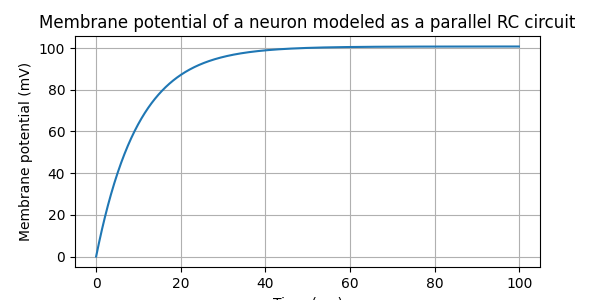

In [47]:
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(600*px, 300*px))
ax.plot(t, V_t)  # plot in mV
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)')
ax.set_title('Membrane potential of a neuron modeled as a parallel RC circuit')
plt.grid()
plt.show()


---

## 1.2: The neuronal membrane: Multiple conductances <a class="anchor" id="tnm"></a>

We are now getting close to <ins>modelling the passive membrane properties</ins> of a real neuron. As you have seen, the Nernst potential calculates the reversal potential for each ion species seperately. To calculate the resting membrane potential, we need <ins>mainly three ion types</ins>: **sodium**, **potassium**, and **chloride**.

In biological neurons, the <ins>reversal potential</ins> for these ions is given by their different concentrations inside and outside the cell. That means, <ins>every ion species</ins> must have its "personal" driving force - a **voltage source**, if you will. Additionally, the membrane is selectively permeable for each ion species (different ion channels allow only crossing for specific ions) - thus also the **conductances** are specific for the ion type ($g_{ion}$).

We start with the following premises:
- Three ions are required to make up the resting membrane potential
- Each ion requires a voltage source and some conductance / resistance
- The cell membrane itself is modelled as a capacitor in parallel to the resistor(s)


Knowing how to model the **Nerst equation** (<ins>single ion</ins>) as an electrical circuit (**parallel RC**) and how the **GHK equation** is used to calculate the <ins>resting membrane potential including sodium, potassium and chloride ions</ins>, you can now get close to model the cell membrane of a neuron.

---

> **Assignment 4**
>
> Draw the equivalent electrical circuit modelling the cell membrane of a neuron with three conductances. Using this equivalent circuit, answer the following questions:
> - What is the relationship between the permeability of the membrane and the resistance for that ion?
> - How can you represent the electrical potential generated by an ion across the membrane?


<font color='red'>**Answer 4**</font>:

![My Image](https://github.com/ManteLab/Iton_notebooks_public/blob/ex2/utils_ex2/ghk_circuit.png?raw=true)

Each ion type can be modelled as a resistor and a battery connected in series.

This simple representation for each given ion can be integrated into a full equivalent circuit for the cell membrane by connecting the circuit for each ion in parallel, and adding a capacitor in parallel to the resistors and batteries.

  - The resistance depends on the permeability of the membrane to that given ion: the higher the permeability, the lower the resistance for that ion.

  - The ion species also generates an electrical potential across the membrane as expressed by its Nernst potential, and is represented by a battery in the model circuit.

---

> **Assignment 5**
>
> Using the equivalent circuit you just drew and Kirchhoff's laws, write the equation for the membrane potential of a neuron.
>
> $V_m =...$

<font color='red'>**Answer 5**</font>:

- The membrane potential $V_m$ is the sum of the potentials generated by each ion across the membrane.
- Using Kirchhoff's current law, the total current entering the node is equal to the total current leaving the node.
- At equilibrium (no net current), the total current entering the node is zero i.e. $I_{in} = 0 = I_{K} + I_{Na} + I_{Cl}$.
- The current through each resistor is given by Ohm's law: $I_{ion} = g_{ion} \cdot (V_m - E_{ion})$ where $g_{ion} = 1/R_{ion}$ is the conductance of the ion channel.
- We then can write
- $0 = g_{K} \cdot (V_m - E_{K}) + g_{Na} \cdot (V_m - E_{Na}) + g_{Cl} \cdot (V_m - E_{Cl})$.
- $\Leftrightarrow 0 = g_{K} \cdot V_m - g_{K} \cdot E_{K} + g_{Na} \cdot V_m - g_{Na} \cdot E_{Na} + g_{Cl} \cdot V_m - g_{Cl} \cdot E_{Cl}$.
- $\Leftrightarrow 0 = (g_{K} + g_{Na} + g_{Cl}) \cdot V_m - g_{K} \cdot E_{K} - g_{Na} \cdot E_{Na} - g_{Cl} \cdot E_{Cl}$.
- $\Leftrightarrow V_m = \frac{g_{K} \cdot E_{K} + g_{Na} \cdot E_{Na} + g_{Cl} \cdot E_{Cl}}{g_{K} + g_{Na} + g_{Cl}}$.

---

> **Assignment 6**
>
> Write a function to simulate the membrane potential using the 3-conductance model.

<font color='red'>**Answer 6**</font>:

In [48]:
def membrane_potential(g_K, E_K, g_Na, E_Na, g_Cl, E_Cl):
    Vm = (g_K * E_K + g_Na * E_Na + g_Cl * E_Cl) / (g_K + g_Na + g_Cl)
    return Vm

---

# 2. Cable equation <a class="anchor" id="ce"></a>


So far, we have discussed membrane properties in steady-state conditions and over time. In neurons, <ins>changes in membrane potential</ins> often initially occur at the tip of long, thin cell membrane protrusions - called **dendrites** - and then <ins>passivly conduct</ins> along these dendrites towards the cell body (**soma**). Large changes in the membrane potential can trigger **action potentials** (**spikes**) at the soma which are propagated actively along the **axon**.

The conduction is most pronounced in long and narrow membrane compartments (dendrite and soma) which may be treated like a ‘cable’. If a cable (or an axon, for that matter), would receive a current input $I_0(t)$ at one end, the voltage change at location of input would depent on Ohms Law.

A typical problem in **cable theory** (Wilfrid Rall, 1977) is to determine the distribution of voltage $V (x, t)$ along the cable (ditance to the site of input $x$) and over time $t$.

![My Image](https://github.com/ManteLab/Iton_notebooks_public/blob/ex2/utils_ex2/ex2_cable.png?raw=true)


## 2.1: Cable resistance <a class="anchor" id="cr"></a>

Electrons when flowing through a cable (of copper for exemple) encounter a resistance due to the atoms in the cable. This is called the longitudinal resistance of the cable and is given by the formula:
$R_L = \frac{r_L \Delta x}{\pi a^2}$ where:
- $r_L$ is the specific longitudinal resistance of the cable [$\Omega \cdot mm$],
- $\Delta x$ is the length of the cable [$mm$].

---

>**Assignment 7**
>
> Given these information and the depiction in the figure above answer the following questions:
>   1. What is the unit of the longitudinal resistance $R_L$?
>   2. If you double the radius $a$ of the cable, what happens to the longitudinal resistance $R_L$?
>   3. If you double the length $\Delta x$ of the cable, what happens to the longitudinal resistance $R_L$?

<font color='red'>**Answer 7.1**</font>:

The unit of the longitudinal resistance is $\Omega$.

<font color='red'>**Answer 7.2**</font>:

If you double the radius $a$ of the cable, the longitudinal resistance $R_L$ is divided by 4.

<font color='red'>**Answer 7.3**</font>:

If you double the length $\Delta x$ of the cable, the longitudinal resistance $R_L$ is doubled.

---

Note, that we can relate the voltage drop along the cable to the current injected into the cable by using Ohm's law:

$\Delta V = - I_L \cdot R_L$ = $- I_L \cdot \frac{r_L \Delta x}{\pi a^2}$.

Applying cable theory to neurons, we established that ions flowing along the longitudinal axis of an axon experience a restistance $R_L$. However, ions do not only travel along the x-axis but also in radial direction. The resitance, ions encounter there is called the membrane resistance and is given by the formula:

$R_m = \frac{r_m}{2 \pi a \Delta x}$ where:
- $r_m$ is the specific membrane resistance [$\Omega \cdot mm^2$],
- $\Delta x$ is the length of the cable [$mm$].
- $a$ is the radius of the cable [$mm$].

---

> **Assignment 8**
> Given these information and the depiction in the figure above answer the following questions:
>
> 1. What is the unit of the membrane resistance $R_m$?
> 2. If you double the radius $a$ of the cable, what happens to the specific membrane resistance $R_m$?
> 3. If you double the length $\Delta x$ of the cable, what happens to the specific membrane resistance $R_m$?

<font color='red'>**Answer 8.1**</font>:

The unit of the longitudinal resistance is $\Omega$.

<font color='red'>**Answer 8.2**</font>:

If you double the radius $a$ of the cable, the specific membrane resistance $R_m$ is divided by 2.

<font color='red'>**Answer 8.3**</font>:

If you double the length $\Delta x$ of the cable, the specific membrane resistance $R_m$ is halved.

---

## 2.2: The cable equation <a class="anchor" id="tce"></a>

For a passive membrane, the membrane potential $V(x,t)$ is determined by solving the following partial differential equation (linear cable equation):
$\tau_m \frac{\partial v}{\partial t} = \lambda^2 \frac{\partial^2 v}{\partial x^2} - v + r_m i_e$
where:
- The time-derivative term $\frac{\partial v}{\partial t}$ relates to chargin of the membrane capacitance.
- The second space-derivative term $\frac{\partial^2 v}{\partial x^2}$ relates to accumulation of longitudinal currents.
- $\tau_m = r_m c_m$ sets the scale for the **temporal** variation in the membrane potential. $\tau_m$ is called the membrane time constant.
- $\lambda = \sqrt{\frac{ar_m}{2r_l}}$ sets the scale for the **spatial** variation in the membrane potential. $\lambda$ is called the electrotonic length constant.
with:
- $c_m$ is the specific membrane capacitance,
- $a$ is the radius of the cable (axon in our case),
- $v = V - V_{rest}$ is the membrane potential relative to the resting potential,
- $r_m$ is the specific membrane resistance (= $1 M\Omega \cdot mm^2$),
- $r_L$ is the longitudinal resistance (= $1 k\Omega \cdot mm$),
- $i_e$ is the current injected into the cable.

---

>**Assignment 9**
>
> Given the information above answer the follwing questions:
>
>$r_m = 1 M\Omega \cdot mm^2$,
>
>$r_L = 1 k\Omega \cdot mm$,
>
>$a = 2 \mu m$
>
>1. What is the unit of the  length constant $\lambda$?
>2. What is the unit of the membrane time constant $\tau_m$?

<font color='red'>**Answer 9.1**</font>:

The unit  of $\lambda$ is $mm$.

<font color='red'>**Answer 9.2**</font>:

The unit  of $\tau_m$ is $ms$.

---

## 2.3: Steady-state solution (infinite cable) <a class="anchor" id="sss"></a>

We assume an infinite long **cable** and inject a constant current $i_e$ locally at $x = 0$.

The steady-state solution (so that $\frac{\partial v}{\partial t} = 0 $) of the cable equation then is:

$v(x) = \frac{i_e R_L}{2} e^{\frac{-|x|}{\lambda}}$ with $R_L = \frac{r_L \lambda}{\pi a^2}$.

Length constant: 1.00 mm


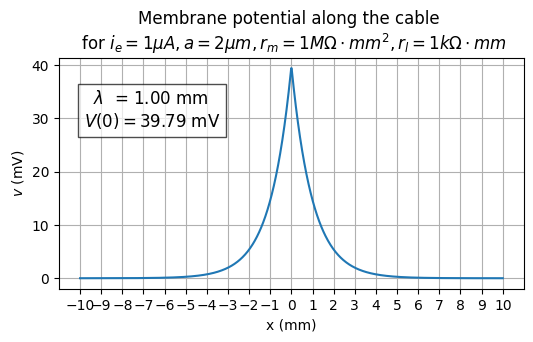

In [49]:
import numpy as np
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
platform = 'notebook'
x = np.linspace(-10, 10, 1000)  # position along the cable in mm


i_e = 1e-6  # injected current in ampere
a = 2e-3  # radius of the cable in mm (2um)
r_m = 1e6  # specific membrane resistance in Ohm * mm^2
r_l = 1e3  # specific longitudinal resistance in Ohm * mm
lambda_elc = np.sqrt((a*r_m) / (2*r_l))  #  length constant in mm
print(f'Length constant: {lambda_elc:.2f} mm')
R_l = r_l * lambda_elc / (np.pi * a**2)  # longitudinal resistance in Ohm

v = (i_e * R_l / 2) * np.exp(-np.abs(x) / lambda_elc)  # membrane potential in mV
v0 = (i_e * R_l / 2)

# Plot the membrane potential along the cable
%matplotlib inline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(600*px, 300*px))
ax.plot(x, v)  # plot in mV
ax.set_xlabel('x (mm)')
ax.set_ylabel(r'$v$ (mV)')
ax.set_title('Membrane potential along the cable \n for ' + r'$i_e = 1 \mu A, a = 2 \mu m, r_m = 1 M\Omega \cdot mm^2, r_l = 1 k\Omega \cdot mm$')
text_display = ax.text(0.2, 0.7, r'$\lambda$ ' + f' = {lambda_elc:.2f} mm \n' + r'$V(0) =$' +  f'{v0:.2f} mV', transform=ax.transAxes, fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.7))
ax.set_xticks(np.arange(-10, 11, 1))
plt.grid()
plt.show()

To get a better understanding for the parameters in the passive cable equation, you can use an interactive plot below to modify the specific resistances $r_L$ and $r_m$ as well as the amount of current injected $i_e$ (at $x=0$) and the radius of the denrite $a$.

In [50]:
%matplotlib widget
# Interactive plots are strange in matplotlib, so if you
# are having issues with interactive plots, run this cell!


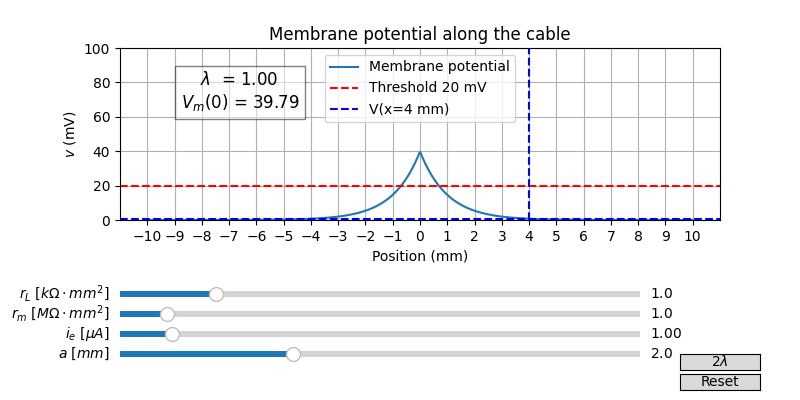

In [51]:
from utils_ex2.utils import plot_cable_v
plt.close()

if platform == 'colab':
  %matplotlib widget

plot_cable_v(y_axis_lim=100, plot_lambda=True) # y_axis_lim is the limit of the y-axis (in mV), default is 80

---

>**Assignment 10**
>Using the provided information (cable equation and interactive plot), answer the following questions:
>
>1. What happens if you increase the radius $a$? (Hint: there is a second, not obvious effect which you can visualize in the interactive plot above by changing the `y_axis_lim` parameter in the function `plot_cable_v` to a lower value (e.g., 20 mV).
>2. What happens if you increase the injected current $i_e$?
>3. What happens if you increase the longitudinal resistance $R_L$? Why?
>4. What happens if you increase the membrane resistance $R_m$? Why?

<font color='red'>**Answer 10.1**</font>: The peak membrane potential decreases but the voltage decays more slowly along the cable. By increasing a, both $R_L$ and $R_m$ decreases, which results in a lower voltage drop per unit length along the cable.

<font color='red'>**Answer 10.2**</font>: The membrane potential at any position along the cable is increased (the voltage is higher).

<font color='red'>**Answer 10.3**</font>: The membrane potential at any position along the cable is decreased (the voltage is lower). By increasing the longitudinal resistance, electrons flow less easily along the cable, which results in a higher voltage drop per unit length along the cable.

<font color='red'>**Answer 10.4**</font>: The membrane potential at any position along the cable is increased (the voltage is higher). By increasing the specific membrane resistance, electrons flow less easily radially through the membrane. The voltage propagates more longitudinally, which results in a lower voltage drop per unit length along the cable.

---

Did you wonder, where the <ins>current that changes our membrane potential</ins> comes from in the first place? In neurons, these inputs are usually caused by ions crossing the membrane via **open ion channels**. Why do they open? That depends on the ion channel and you will hear a lot more about this during the rest of the course. For now, we assume that the <ins>initial current input</ins> at $x=0$ <ins>is just a given</ins>.

However, along the axon we find more ion channels (let's assume that they allow sodium ions to enter the axon, when open). These channels are likely closed but <ins>change their probability to open</ins> if the <ins>membrane potential at their location crosses a certain **threshold**</ins>. We call them **voltage-gates ion channels**.

---

>**Assignment 11**
>
>In the code for the interactive plot above, find the function `plot_cable_v` and change the value of the parameter `plot_lambda` to `True`, then rerun the cell. This will plot the vertical line at x=4mm, which represents twice the length constant $\lambda$. It will also plot a horizontal line showing the membrane potential at x=4mm.
>
>Press the button $2\lambda$ (above the ` Reset ` button). This will set $r_m = 6.4 MΩ·mm^2$, $r_l = 0.8 kΩ·mm$ and $a = 1 μm$. >It also sets the injected current $i_e = 0.39 μA$, resulting in a membrane potential of 100 mV at $x = 0$.

---


In the plot above, we generate a <ins>prolonged atrificial "spike"</ins> (assume constant current injection) at $x = 0$ to generate a peak voltage of 100mV.

The voltage-gated sodium channels at $x = 2\lambda = 4 mm$ could allow the artificial spike to actively propergate further if the membrane potential at location exceeded their opening-**theshold** voltage of 20mV (let the resting potential be 0V).


---

>**Assignment 12**
>
>1. Looking at the interactive plot above, will these settings allow the spike to be actively propagated beyond $x = 2\lambda = 4 mm$?
> 2. Double the radius of the axon. This will change $\lambda$ but we keep the absolute position of the two nodes fixed i.e $x_0 = 0$ and $x_1 = 4 mm$. What happems to the membrane potential at $x=0$? How much current do we need to inject into the axon to again reach a membrane potential of 100mV at $x = 0$?
> 3. After adjusting the injected current, do the new parameters allow the spike to be actively propagated beyond $x = 2\lambda = 4 mm$?

<font color='red'>**Answer 12.1**</font>: No.

<font color='red'>**Answer 12.2**</font>: 1.11 μA.

<font color='red'>**Answer 12.3**</font>: Yes.

---

## 2.4: An axon with three injection sites <a class="anchor" id="axon"></a>

Next, we assume again an infinite cable but this time we inject constant currents $i_{1}$, $i_{2}$ and $i_{3}$ simultaneously at three locations: $x = 0$, $x = x_1$ and $x = x_2$.

Here the linear cable equation that we have already introduced for all three injection sites:

$\tau_m \frac{\partial v_1}{\partial t} = \lambda^2 \frac{\partial^2 v_1}{\partial x^2} - v + r_m i_{e_1}$ for $x = 0$

$\tau_m \frac{\partial v_2}{\partial t} = \lambda^2 \frac{\partial^2 v_2}{\partial x^2} - v + r_m i_{e_2}$ for $x = x_1$

$\tau_m \frac{\partial v_3}{\partial t} = \lambda^2 \frac{\partial^2 v_3}{\partial x^2} - v + r_m i_{e_3}$ for $x = x_2$

Then the steady-state membrane potential at location $V(x)$ is given by :

$V(x) = \frac{R_L}{2} (i_{0} e^{\frac{-|x - x_0|}{\lambda}} + i_{1} e^{\frac{-|x_1|}{\lambda}} + i_{2} e^{\frac{-|x - x_2|}{\lambda}})$.


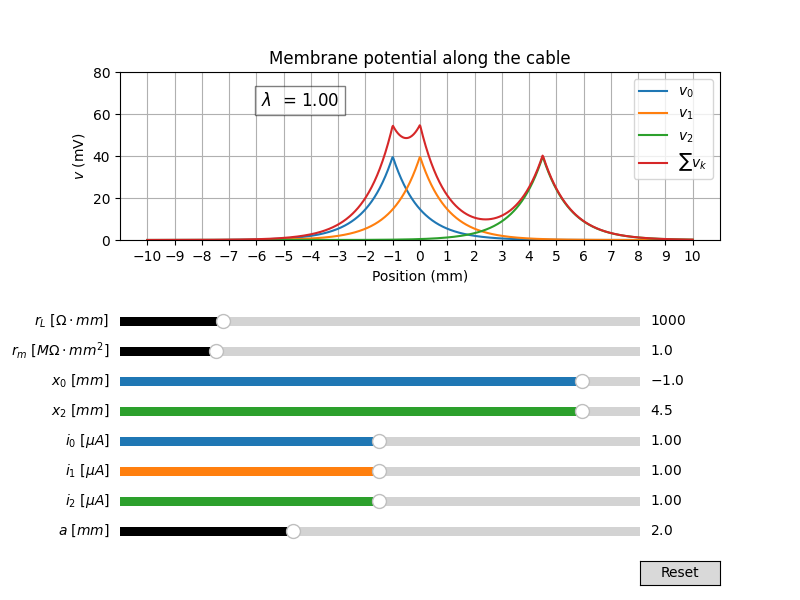

In [52]:
from utils_ex2.utils import plot_multi_injection
if platform == 'colab':
  %matplotlib widget
plot_multi_injection(y_axis_lim=80)

In the last assignment we saw that input (current injection) at $x=0$ propagates along an axon where it may or may not trigger a spike at $x=4mm$. Although the mechanism of **action potential propagation** in biological axons is more complicated (we will hear about this later during the course), the general idea of what we saw, holds true.



---

>**Assignment 13**
>
>In the **interactive plot** above you can change individual parameters of three current injections. Adjust the settings and observe, what changes. Note that $x_0$ can only occure to the left of $x_1$ and $x_2$ will only occure to the right of $x_1$.

<font color='red'>**Answer 13**</font>: Multiple observations are possible. All align with predictions from the cable equation. Examples: higher input amplitudes, higher $r_L$, higher $r_m$ or lower $a$, all result in larger voltage amplitudes.

---



We use this example to showcase an interesting mechanism found in neurons: summation of inputs.

---

>**Assignment 14**
>
>Compare the single-input case with the three-inputs case and try to answer the following questions:
>
>- Which of the two cases is more relevant for action potential propagation in axons and why?
>- What exactly does the red line in the interactive plot above show and how relevant is this line for biological axons?
>-  Try to identify three details in the cable equation models above that incorrecly, inadequately, incompletely or poorly represent the mechanisms in biological neurons.

<font color='red'>**Answers 14**</font>: In neurons the AP is initiated close to the soma and propagates along the axon. On a scale where we focus on the axon as a whole, the single-input case mimics the behaviour of action potential propagation closer. However, if we zoomed in, we would find individual sodium channels close to each other that open due to a proximate voltage increase (voltage-gated). The individual input currents of all channels contribute to the overall potential change. Their sum would be the red line in the plot above. Depending on the scale at which we interpret our model, both have some validity.

---

# 3. Integrate-and-Fire neuron and delayed synaptic inputs <a class="anchor" id="if"></a>

You now have a good understanding of **cable theory** and how passive conduction affects voltage distribution along a neuron’s axon or dendrite. As mentioned already, inputs arriving somewhere along dendrites passivly travel to the soma where they are **integrated**.

The **cable equation** has provided us with the tools to calculate how signals <ins>attenuate and decay</ins> as they conduct along a dendrite. Building on this foundation, we introduce the **Integrate-and-No-Fire neuron model** — a simplified representation of **neuronal input integration**.

The following properties of a neuron can be studied using the the Integrate-and-No-Fire model:

  1.	**Input integration**: How a neuron accumulates inputs from multiple synapses over time.
  2.	**Synaptic weights**: How varying synaptic strengths impact membrane potential changes.
  3.	**Delays**: How the physical properties of dendrites introduce delays in signal propagation.
  4.	**Summation**: How inputs arriving at different times and different locations along the dendrites are summed.



## 3.1: Delays: How cable theory affects synaptic inputs <a class="anchor" id="cable"></a>

In the previous section, we have learned that the **passive properties** of **dendrites** cause the membrane potential to attenuate and decay as they travel towards the soma. Note, that passive propagation doesn't happen instantaneously. Aided by insights of **cable theory**, the delay  $d_i$ for a synaptic input located at a distance  $x_i$  is given by:


$d_i = \frac{x_i}{v}$

where  $v$  is the propagation velocity along the dendrite, calculated using physical properties such as the length constant ${\lambda}$ and the membrane time constant ${\tau_m}$. $v$ is given by:

$v = \frac{2\lambda}{\tau_m}$

These equations highlight how dendritic properties like resistance, capacitance, and geometry influence the time it takes for a synaptic input to arrive at the soma.



## 3.2: The Integrate-and-No-Fire Model <a class="anchor" id="inf"></a>

In the Integrate-and-No-Fire model, we model the neuron’s membrane potential  V(t) at the soma as the cumulative sum of all synaptic inputs that have arrived up to time $t$. Each synaptic input contributes to the membrane potential based on its:

-	Synaptic weight ( $w_i$ ): The strength of the synaptic input.
-	Delay ( $d_i$ ): The time it takes for the input to reach the soma.



Mathematically, the membrane potential can be expressed as:


$V(t) = V_{\text{rest}} + \sum_{i=1}^{N} \sum_{j} w_i \cdot \delta(t - (s_{ij} + d_i))$

-	 $V_{\text{rest}}$ : Resting membrane potential (set to 0 for simplicity).
-	 $N$ : Number of synapses.
-	 $s_{ij}$ : Input times $j$ at synapse $i$ (note that multiple inputs could arrive at a single synapse).
-	 $\delta$ : Kronecker delta function, ensuring the input is considered only if $t = s_{ij} + d_i$ .

In [53]:
from utils_ex2.utils import iplot_InoF_model
iplot_InoF_model()

interactive(children=(FloatSlider(value=5.0, description='Synaptic  Weight 1:', step=5.0, style=SliderStyle(de…

---

**The answers to these questions are in the cell below.**

>**Assignment 15**
>
>Without changing parameters in the interactive plot obove, look at the input times in all three synapses. How long do the delays $d_1$, $d_2$, and $d_3$ have to be, so that all three inputs arriveat the soma simultaneously at  t=50ms? Adjust the synaptic delays $d_i$ using the sliders and explain how this synchronization will affect the membrane potential at  t=50ms.

---

Using the provided “Integrate-and-No-Fire” model, consider three synapses located along a dendrite at different distances from the soma:

-	Synapse 1 is located at a distance  $x_1$ = 1  mm from the soma.
-	Synapse 2 is located at  $x_2$ = 2  mm.
-	Synapse 3 is located at  $x_3$ = 3  mm.

All synapses receive inputs at t=10ms and t=40ms and each input changes the membrane potential locally to +1mV.

Assume the following parameters for the dendrite:

-	Membrane resistance per unit length:  $r_m$ = 1  MΩ·mm
-	Axial (internal) resistance per unit length:  $r_i$ = 100  Ω·mm
-	Membrane capacitance per unit length:  $c_m$ = 1  μF/mm
- Uniform radius of $a$ = 1 mm
- Membrane time constant $\tau_m$ = 1 s
-	The dendrite is modeled as a passive cable with uniform properties, assuming that only delay but not voltage is affected by the resistance.

---

>**Assignment 16**
>
>- Calculate the delays  $d_i$  for each synaptic input.
>- Compute the somatic membrane potential  $V(t)$  at  t=50ms using the calculated delays (synaptic weights $w_1$ = 5, $w_2$ = 10, and $w_3$ = 15).

---

Remember when we talked about action potential propagation along the axon (2.c) and wondered where the original input comes from? At the **axon hillock**, the area at the soma where the axon starts, synaptic inputs are integrated - if the membrane potential there crosses a certain theshold, the neuron will fire an action potential.

Our "Integrate-and-No-Fire” model does not implement this functionality by definition (that's why we call it "no-fire"). In the next exercise we will implement finally upgrade and work with an "Integrate-and-Fire” model.

Until then, consider a neuron that does have a threshold to trigger action potentials at $V_{th} = 15 mV$. It receives two synaptic inputs of $1mV$ that individually are not sufficient to cross the firing threshold. However, both inputs combined can cause the neuron to fire. The synaptic weights are  $w_1 = w_2 = 10$, and the delays are $d_1 = d_2 = 5 ms$.

---

>**Assignment 17**
>
> Determine at what time (if at all) the neuron fires given that:
>- Inputs to synapse 1 arrive at  $t_1 = 10 \text{ms}$  and  $t_2 = 30 \text{ms}$.
>- Inputs to synapse 2 arrive at  $t_1 = 10 \text{ms}$  and  $t_2 = 12 \text{ms}$.

---

>**Assignment 18**
>
>Modify the mathematical model to include membrane potential attenuation with a time constant  $\tau_m$. Write the updated equation for $V(t)$ and explain how this changes the neuron’s response to synaptic inputs.
---



<font color='red'>**Answers**</font>

**Question 1:** <br>
Calculating Required Delays: <br><br>
  Synapse 1: <br>
  Excitatory potential at  $s_{1} = 20  \text{ms}$ <br>
  Required delay:  $d_1 = 50 - 20 = 30 \text{ms}$ <br>
<br>
  Synapse 2: <br>
  Original spike at  $s_{2} = 30 \text{ms}$ <br>
  Required delay:  $d_2 = 50 - 30 = 20 \text{ms}$ <br>
<br>
  Synapse 3: <br>
  Original spike at  $s_{3} = 40 \text{ms}$ <br>
  Required delay:  $d_3 = 50 - 40 = 10 \text{ms}$ <br>

<br>
Effect on Membrane Potential:

At  $t = 50  \text{ms}$, all the three (delayed) potentials coincide, which results in a large, single step increase in the $V_mem$ demonstrating enhanced temporal summation.
<br><br>


**Question 2:**

Synapse locations:
 $x_1 = 1 \text{mm}$<br>
 $x_2 = 2 \text{mm}$<br>
 $x_3 = 3 \text{mm}$<br>

Excitatory potentials @ $t_1 = 10 \text{ms}$ and $t_2 = 40 \text{ms}$<br>

Synaptic weights:<br>
$W_1 = 5$<br>
$W_2 = 10$<br>
$W_3 = 15$<br>

Calculating the Synaptic Delays  $d_i$:<br>

To calculate the synaptic delays, we use the concept of signal propagation along a passive dendritic cable. The delay  $d_i$  for a synaptic input traveling from its location  $x_i$  to the soma is given by:<br>


$d_i = \frac{x_i}{v}$<br>


where  $v$  is the propagation velocity along the dendrite.<br>

Therefore, the propagation velocity  v  in a passive cable is:<br>

$v = \frac{\lambda}{\tau_m}$<br>

$\lambda$  is the length constant, defined as  $\lambda = \sqrt{\frac{r_m}{r_i}}$<br>

Given:<br>
$r_m = 1  MΩ·mm  = 1 \times 10^6  Ω·mm$<br>
$r_i = 100  Ω·mm$<br>


$\lambda = \sqrt{\frac{r_m}{r_i}}
= \sqrt{\frac{1 \times 10^6 \text{ Ω·mm}}{100 \text{ Ω·mm}}}
= \sqrt{10^4}
= 100 \text{ mm}$<br>


Calculating the propagation velocity  $v$ :<br>


$v = \frac{\lambda}{\tau_m} = \frac{100 \text{ mm}}{1 \text{ s}} = 100 \text{ mm/s}$<br>


Now, let's calculate the delays  $d_i$ :<br>

For Synapse 1 ($x_1 = 1  mm$):<br>

$d_1 = \frac{x_1}{v} = \frac{1 \text{ mm}}{100 \text{ mm/s}} = 0.01 \text{ s} = 10 \text{ ms}$<br>

For Synapse 2 ($x_2 = 2  mm$):<br>

$d_2 = \frac{x_2}{v} = \frac{2 \text{ mm}}{100 \text{ mm/s}} = 0.02 \text{ s} = 20 \text{ ms}$<br>

For Synapse 3 ($x_3 = 3  mm$):<br>

$d_3 = \frac{x_3}{v} = \frac{3 \text{ mm}}{100 \text{ mm/s}} = 0.03 \text{ s} = 30 \text{ ms}$<br>


2. Computing the Membrane Potential  $V(t)$  at  $t = 50  \text{ms}$:<br>

Determine the delayed spike arrival times for each synapse:<br>

Original spike times are at  t = 10  ms and  t = 40  ms.<br>

Synapse 1 ($d_1 = 10 \text{ms}$):<br>

Delayed spike times:<br>
$t_{1a} = 10 \text{ ms} + 10 \text{ ms} = 20 \text{ ms}$<br>
$t_{1b} = 40 \text{ ms} + 10 \text{ ms} = 50 \text{ ms}$<br>

Synapse 2 ($d_2 = 20 \text{ms}$):<br>

Delayed spike times:<br>
$t_{2a} = 10 \text{ ms} + 20 \text{ ms} = 30 \text{ ms}$<br>
$t_{2b} = 40 \text{ ms} + 20 \text{ ms} = 60 \text{ ms}$<br>

Synapse 3 ($d_3 = 30  \text{ms}$):<br>

Delayed spike times:<br>
$t_{3a} = 10 \text{ ms} + 30 \text{ ms} = 40 \text{ ms}$<br>
$t_{3b} = 40 \text{ ms} + 30 \text{ ms} = 70 \text{ ms}$<br>

Calculate  $V(t)$  at each relevant time up to  t = 50  ms:<br>

At  t = 20  ms:<br>

Synapse 1 contributes  $w_1 = 5$<br>
$V(20 \text{ ms}) = 0 + (5 * 1 \text{ mV}) = 5 \text{ mV} $<br>

At  t = 30  ms:<br>
Synapse 2 contributes  $w_2 = 10$<br>
$V(30 \text{ ms}) = V(20 \text{ ms}) + (10 * 1 \text{ mV}) = 5 \text{ mV} + 10 \text{ mV} = 15 \text{ mV} $<br>

At  t = 40  ms:<br>
Synapse 3 contributes  $w_3 = 15$<br>
$V(40 \text{ ms}) = V(30 \text{ ms}) + (15 * 1 \text{ mV}) = 15 \text{ mV} + 15 \text{ mV} = 30 \text{ mV}$<br>

At  t = 50  ms:<br>
Synapse 1 contributes again  $w_1 = 5$<br>
$V(50 \text{ ms}) = V(40 \text{ ms}) + (5 * 1\text{ mV}) = 30 \text{ mV} + 5 \text{ mV} = 35 \text{ mV} $<br>

Answer:<br>

At  $t = 50 \text{ms}$, the membrane potential  $V(50 \text{ ms})$  is $35 \text{mV}$.

<br><br>

**Question 3:**

1.  Arrival times: <br>
  $t_{1} = 10 + 5 = 15 \text{ms}$ <br>
  $t_{2} = 30 + 5 = 35 \text{ms}$
  
  Membrane potential updates:<br>
  At  $t = 15 \text{ms} :  V(15) = 0 + (1 \text{mV} * 10) = 10 \, \text{mV}$ <br>
  At  $t = 35 \text{ms} :  V(35) = V(15) + (1 \text{mV} * 10) = 10 + 10 = 20 \text{mV}$ <br><br>
  
  Neuron fires at  $t = 35 \text{ms}$

<br>

2.  Arrival times: <br>
  $t_{1} = 10 + 5 = 15 \text{ms}$ <br>
  $t_{2} = 12 + 5 = 17 \text{ms}$ <br>
  
  Membrane potential updates: <br>
  At  $t = 15 \text{ms} :  V(15) = 0 + (1 \text{mV} * 10) = 10 \, \text{mV}$ <br>
  At  $t = 17 \text{ms} :  V(17) = V(15) + (1 \text{mV} * 10) = 10 + 10 = 20 \text{mV}$ <br><br>
  
  Neuron fires at  $t = 17 \text{ms}$


<br><br>
**Question 4:**

<br>With membrane decay, the membrane potential at each time step decays towards a resting potential (0 mV) and is incremented by any arriving synaptic inputs. Adding a small decay factor to the $V_\text{Rest}$ (denoted as $V(t - \Delta t)$ for representing the previous timestep) of the equation of the Integrate-and-No-Fire model would help us achieve this. The updated equation will be:


$V(t) = V(t - \Delta t) \cdot e^{-\Delta t / \tau_m} + \sum_{i} \sum_{j} w_i \cdot \delta(t - (s_{ij} + d_i))$


<br>This changes the neuron’s response by causing  V(t)  to decrease over time in the absence of inputs, preventing indefinite accumulation of potential. The neuron now requires more closely timed inputs to reach higher membrane potentials (In order to surpass the threshold) due to the decay.

---

# End of this exercise session